# **Classificação Temática e Análise de Sentimentos de Postagens do Reddit**

O objetivo desse trabalho é a partir de um modelo de classifição realizar uma análise temática de publições feitas no Reddit e posteriormente realizar o estudo de sentimentos acerca das mesmas.

# **1 - Base de dados**

A primeira etapa para o desenvovimento do projeto consiste em importar as bibliotecas necessarias para a análise e agrupamentos dos dados, destacando a biblioteca PRAW que permite a interação com a API do Reddit de maneira fácil.

In [1]:
!pip install praw
!pip install torch transformers
!pip install emoji
!pip install spacy
!pip install numpy==1.24.4 catboost==1.2.2
!pip install lightgbm

import praw  # Biblioteca para acessar a API do Reddit e coletar dados de postagens, usuários e comentários.
import json  # Biblioteca para manipulação de dados no formato JSON, comum para APIs e arquivos estruturados.
import nltk  # Biblioteca para processamento de linguagem natural (PLN), incluindo tokenização e análise de sentimentos.
import pandas as pd  # Biblioteca para manipulação e análise de dados estruturados em DataFrames.
import numpy as np  # Biblioteca para operações matemáticas e manipulação eficiente de arrays multidimensionais.
import string  # Biblioteca para manipulação de strings, como remoção de pontuações.
import threading  # Biblioteca para executar múltiplas tarefas simultaneamente usando threads.
import torch  # Biblioteca para computação em machine learning e deep learning, usada principalmente com PyTorch.
import re # Biblioteca para importar as expressoes regulares
import emoji # Biblioteca para listar os emojis
import spacy # Biblioteca necessaria para utilizar o REN
import matplotlib.pyplot as plt # Biblioteca utilizar para gerar gráficos
from sklearn.model_selection import train_test_split  # Biblioteca para dividir os dados em conjuntos de treino e teste.
from sklearn.feature_extraction.text import TfidfVectorizer  # Biblioteca para transformar texto em representações numéricas usando TF-IDF.
from sklearn.naive_bayes import MultinomialNB  # Biblioteca para classificação de textos usando o modelo Naive Bayes.
from sklearn.metrics import classification_report  # Biblioteca para gerar métricas de desempenho da classificação.
from nltk.corpus import stopwords  # Biblioteca que contém listas de palavras irrelevantes para PLN (stopwords).
from wordcloud import WordCloud  # Biblioteca para gerar nuvens de palavras a partir de textos.
from collections import Counter  # Biblioteca para contar a frequência de elementos em listas ou iteráveis.
from collections import defaultdict  # Biblioteca para criar dicionários com valores padrão dinâmicos.
from nltk.sentiment import SentimentIntensityAnalyzer  # Biblioteca para análise de sentimentos baseada no modelo VADER.
from concurrent.futures import ThreadPoolExecutor  # Biblioteca para paralelizar tarefas usando múltiplas threads.
from transformers import AutoTokenizer, AutoModelForSequenceClassification  # Biblioteca para carregar modelos pré-treinados de NLP, como LM-RoBERTa.
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay,  roc_curve, auc
from tqdm import tqdm
from sklearn.utils.class_weight import compute_sample_weight, compute_class_weight

print("Bibliotecas carregadas")


Bibliotecas carregadas


Logo em seguida vamos configurar a API do Reddit via PRAW.

In [2]:
from google.colab import userdata
client_id = userdata.get("reddit_client_id")
assert client_id is not None
client_secret = userdata.get("reddit_client_secret")
assert client_secret is not None
app_name = userdata.get("reddit_app")
reddit = praw.Reddit(client_id=client_id,
                     client_secret=client_secret,
                     user_agent=app_name)
print("API linkada")

API linkada


Com a API configurada já é possível fazer extração de publicações desejadas. O objetivo modelo será classificar publicações dentre as seguintes temáticas:

*   **Política**
*   **Economia**
*   **Religião**
*   **Entretenimento**

Para isso vou utilizar de subreddits (comunidades dentro da plataforma) nichadas, ou seja, que são especificas para discurssão dos temas escolhidos, onde serão retiradas 1000 publicações de cada comunidade a fim de treinar o nosso modelo.


In [3]:
# Definir os subreddits por tema
subreddits = {
    "politica": ["brasilivre", "brasildob"],
    "economia": ["investimentos", "empreendedorismo"],
    "religiao": ["brasil", "ateismo_br"],
    "entretenimento": ["filmeseseries", "MusicaBR"]
}

# Função para coletar postagens de um subreddit
def coletar_postagens(subreddit_nome, limite=1000):
    postagens = []
    subreddit = reddit.subreddit(subreddit_nome)

    for submission in subreddit.new(limit=limite):
        postagens.append({
            'titulo': submission.title,
            'corpo': submission.selftext,
            'upvotes': submission.ups,
            'data_criacao': submission.created_utc,
            'url': submission.url
        })

    return postagens

# Coletar e armazenar dados em um dataframe
dados = []

for tema, lista_subreddits in subreddits.items():
    print(f"Coletando postagens de {tema}...")
    for nome_subreddit in lista_subreddits:
        postagens = coletar_postagens(nome_subreddit)
        for postagem in postagens:
            postagem['tema'] = tema
        dados.extend(postagens)

# Converter os dados para um DataFrame
df = pd.DataFrame(dados)

# Salvar os dados em um arquivo CSV
df.to_csv('postagens_reddit.csv', index=False)

print("Coleta concluída e salva em 'postagens_reddit.csv'")


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Coletando postagens de politica...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

Coletando postagens de economia...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

Coletando postagens de religiao...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

Coletando postagens de entretenimento...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

Coleta concluída e salva em 'postagens_reddit.csv'


# **1 - EDA**

In [4]:
Amostra = pd.read_csv('postagens_reddit.csv')
Amostra.head()

,titulo,corpo,upvotes,data_criacao,url,tema
0,STJ mantém multa contra casal que não vacinou ...,NaN,1,1.742601e+09,https://blog.pirataspelomundo.com.br/2025/03/s...,politica
1,Me ajudem damas.,Estou querendo dar um kit de shampoos pra uma ...,1,1.742600e+09,https://www.reddit.com/r/brasilivre/comments/1...,politica
2,Seria cômico se não fosse trágico,NaN,15,1.742598e+09,https://i.redd.it/oexyqj6dh4qe1.jpeg,politica
3,💬👆,NaN,68,1.742597e+09,https://i.redd.it/1g08x578f4qe1.png,politica
4,Tara da esquerda com o BRICS,Não entendo qual a tara da esquerda com o BRIC...,12,1.742596e+09,https://www.reddit.com/r/brasilivre/comments/1...,politica


In [5]:
Amostra.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7740 entries, 0 to 7739
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   titulo        7740 non-null   object 
 1   corpo         4589 non-null   object 
 2   upvotes       7740 non-null   int64  
 3   data_criacao  7740 non-null   float64
 4   url           7740 non-null   object 
 5   tema          7740 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 362.9+ KB


Podemos observar que a unica feature que possue valores nulos seria "Corpo", o corpo da publicação seria o local onde o usuário pode acrescentar uma imagem, vídeo ou até mesmo criar uma publicação mais extensa. Por esses motivos não necessariamente devemos tratar os valores nulos que esse feature possue.

Vamos fazer uma checagem rápida para explorar se existem duplicatas no dataset Amostra

In [6]:
def checar_duplicadas(df):
    # Verifica linhas duplicadas
    duplicadas = df[df.duplicated()]

    if duplicadas.empty:
        print("✅ Nenhuma linha duplicada encontrada.")
    else:
        print(f"⚠️ Foram encontradas {duplicadas.shape[0]} linhas duplicadas:")
        print(duplicadas)

In [7]:
checar_duplicadas(Amostra)

✅ Nenhuma linha duplicada encontrada.


Para conseguir fazer uma melhor analíse sobre os dados obtidos, apliquei filtros sobre os textos que irão melhorar a perfomance dos algoritmos, entre eles foram retirados URLS, emojis, stopwords, etc...

In [8]:
# Baixar stopwords se ainda não tiver
nltk.download('stopwords')

# Carregar stopwords para português
stopwords_pt = set(stopwords.words('portuguese'))

# Função de limpeza
def limpar_texto(texto):
    if isinstance(texto, float):  # Evitar erro se houver valores NaN
        return ""

    texto = texto.lower()  # Converter para minúsculas
    texto = re.sub(r"http[s]?://\S+", "", texto)  # Remover URLs
    texto = re.sub(r"@\w+", "", texto)  # Remover menções
    texto = re.sub(r"#\w+", "", texto)  # Remover hashtags
    texto = re.sub(r"^>.*", "", texto, flags=re.MULTILINE)  # Remover citações
    texto = re.sub(r"\b\d{1,2}[/.-]\d{1,2}[/.-]\d{2,4}\b", "", texto)  # Remover datas
    texto = emoji.replace_emoji(texto, replace="")  # Remover emojis
    texto = re.sub(r"\b(kkk+|hahaha+|rsrs+|hehe+)\b", "", texto)  # Remover risadas
    texto = " ".join([palavra for palavra in texto.split() if palavra not in stopwords_pt])  # Remover stopwords

    return texto.strip()

# Aplicar limpeza no título e no corpo da postagem
Amostra["titulo"] = Amostra["titulo"].apply(limpar_texto)
Amostra["corpo"] = Amostra["corpo"].apply(limpar_texto)

# Salvar dataset atualizado (substituindo as colunas originais)
Amostra.to_csv("postagens_reddit_limpo.csv", index=False)

print("Limpeza concluída! Dados salvos em 'postagens_reddit_limpo.csv'.")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Limpeza concluída! Dados salvos em 'postagens_reddit_limpo.csv'.


Utiizei o REN ( Reconheicmento de Entidades Nomeadas) uma tecnica que explora entidades nomeadas nas publicações através de um modelo pré-treinado do SpaCy. Essa  técina irá classificar as entidades em três categorias diferentes Pessoa, Localização e Organização, as entidades que não se encaixam nessas classificações são dadas como diversas. Com esses dados a mais espero poder aumentar a eficiencia do modelo de classicação, uma vez que, para determinado tema das publicações ele tera uma ideia das palavras mais utilizadas.

In [9]:
!python -m spacy download pt_core_news_sm
nlp = spacy.load("pt_core_news_sm")

# Função para extrair entidades nomeadas de um texto
def extrair_entidades(texto):
    if pd.isna(texto):
        return ""  # Retornar string vazia para valores NaN
    if not isinstance(texto, str):
        texto = str(texto) # converte para string
    doc = nlp(texto)
    entidades = [ent.text for ent in doc.ents]  # Extrair o texto das entidades
    return ", ".join(entidades)  # Retorna as entidades como uma string separada por vírgulas

# Aplicar a função de REN na coluna 'titulo' e 'corpo'
Amostra["entidades_titulo"] = Amostra["titulo"].apply(extrair_entidades)
Amostra["entidades_corpo"] = Amostra["corpo"].apply(extrair_entidades)

# Salvar o dataset com as entidades extraídas
Amostra.to_csv("postagens_reddit_com_entidades.csv", index=False)

print("Entidades extraídas e salvas em 'postagens_reddit_com_entidades.csv'.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 85.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
Entidades extraídas e salvas em 'postagens_reddit_com_entidades.csv'.


In [10]:
amostra_final = pd.read_csv('postagens_reddit_com_entidades.csv')
amostra_final.head()

,titulo,corpo,upvotes,data_criacao,url,tema,entidades_titulo,entidades_corpo
0,stj mantém multa contra casal vacinou filha co...,NaN,1,1.742601e+09,https://blog.pirataspelomundo.com.br/2025/03/s...,politica,stj,NaN
1,ajudem damas.,"querendo dar kit shampoos pra mulher, quais ma...",1,1.742600e+09,https://www.reddit.com/r/brasilivre/comments/1...,politica,NaN,NaN
2,cômico trágico,NaN,15,1.742598e+09,https://i.redd.it/oexyqj6dh4qe1.jpeg,politica,NaN,NaN
3,NaN,NaN,68,1.742597e+09,https://i.redd.it/1g08x578f4qe1.png,politica,NaN,NaN
4,tara esquerda brics,"entendo tara esquerda brics. imagina esquerda,...",12,1.742596e+09,https://www.reddit.com/r/brasilivre/comments/1...,politica,NaN,"rússia, china, índia, arábia saudita, eua"


In [11]:
valores_nulos = amostra_final.isnull().sum()
valores_nulos

,0
titulo,34
corpo,3264
upvotes,0
data_criacao,0
url,0
tema,0
entidades_titulo,5010
entidades_corpo,4945


In [12]:
amostra_final = amostra_final.dropna(subset=['titulo']).reset_index(drop=True)
amostra_final

,titulo,corpo,upvotes,data_criacao,url,tema,entidades_titulo,entidades_corpo
0,stj mantém multa contra casal vacinou filha co...,NaN,1,1.742601e+09,https://blog.pirataspelomundo.com.br/2025/03/s...,politica,stj,NaN
1,ajudem damas.,"querendo dar kit shampoos pra mulher, quais ma...",1,1.742600e+09,https://www.reddit.com/r/brasilivre/comments/1...,politica,NaN,NaN
2,cômico trágico,NaN,15,1.742598e+09,https://i.redd.it/oexyqj6dh4qe1.jpeg,politica,NaN,NaN
3,tara esquerda brics,"entendo tara esquerda brics. imagina esquerda,...",12,1.742596e+09,https://www.reddit.com/r/brasilivre/comments/1...,politica,NaN,"rússia, china, índia, arábia saudita, eua"
4,política acho,NaN,0,1.742595e+09,https://i.redd.it/soref2s8a4qe1.jpeg,politica,NaN,NaN
...,...,...,...,...,...,...,...,...
7701,apenas relembrando deste clássico traz reflexã...,[vespas mandarinas - sei fazer comigo](,4,1.738804e+09,https://www.reddit.com/r/MusicaBR/comments/1ii...,entretenimento,NaN,NaN
7702,viram maravilha? vale pena!,algumas curiosidades: klaus nomi nasceu aleman...,23,1.738801e+09,https://v.redd.it/ypbev7a7xehe1,entretenimento,NaN,"klaus nomi, alemanha nazista, eua, david bowie..."
7703,provavelmente maior show metal últimas duas dé...,"sinceramente, dor alma poder ir. gosto todas b...",129,1.738801e+09,https://i.redd.it/djfq4hqkwehe1.png,entretenimento,NaN,NaN
7704,músicas apocalípticas,gostaria indicações músicas brasileiras fim mu...,6,1.738800e+09,https://www.reddit.com/r/MusicaBR/comments/1ii...,entretenimento,NaN,NaN


Gerando a núvem de palavras se ter uma ideia mais visual das palavras que são utlizadas em cada tema.

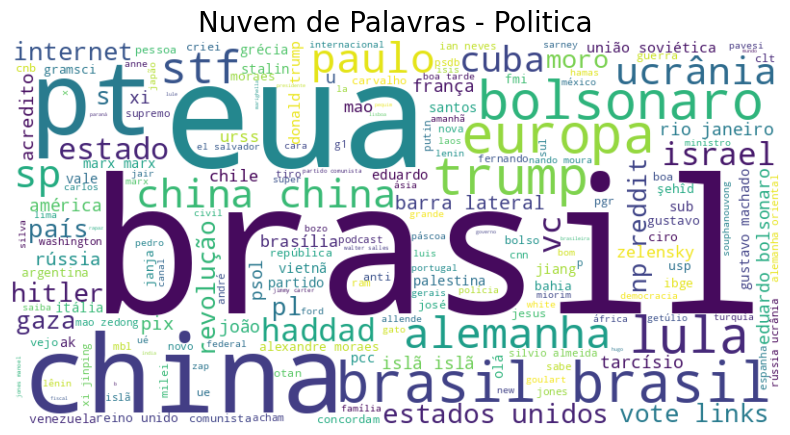

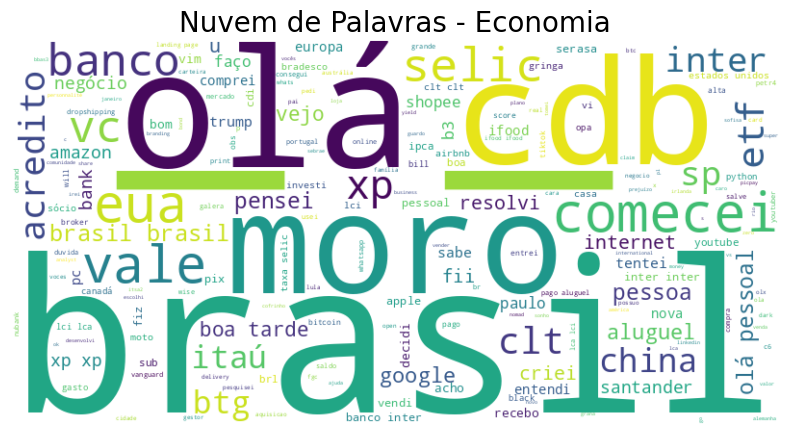

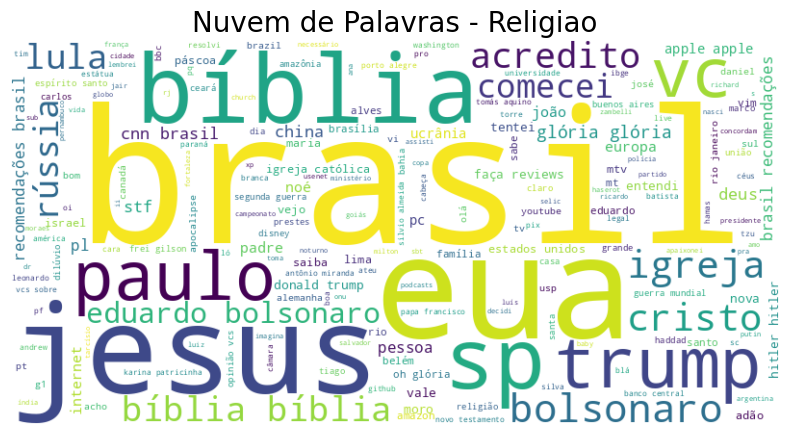

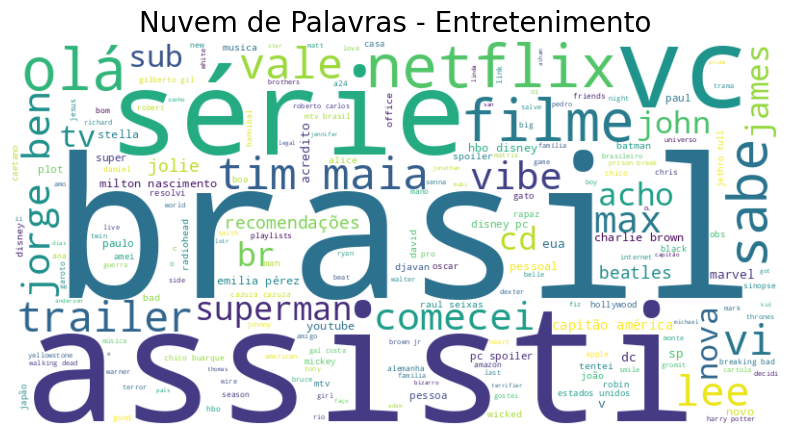

In [13]:
# Função para extrair entidades nomeadas
def extrair_entidades(texto):
    if pd.isna(texto):
        return []  # Retornar lista vazia para valores NaN
    if not isinstance(texto, str):
        texto = str(texto)  # Convert to string if not already
    doc = nlp(texto)
    entidades = [ent.text for ent in doc.ents]  # Extract named entities
    return entidades

# Aplica a função para extrair as entidades de 'titulo' e 'corpo'
amostra_final["entidades_titulo"] = amostra_final["titulo"].apply(extrair_entidades)
amostra_final["entidades_corpo"] = amostra_final["corpo"].apply(extrair_entidades)

# Gerar nuvem de palavras para cada tema combinando título e corpo
themes = ['politica', 'economia', 'religiao', 'entretenimento']
for theme in themes:
    df_theme = amostra_final[amostra_final['tema'] == theme]

    # Combina entidades do título e corpo
    entidades_theme = []
    for _, row in df_theme.iterrows():
        entidades_theme.extend(row["entidades_titulo"])
        entidades_theme.extend(row["entidades_corpo"])

    # Verificar se há entidades para o tema
    if not entidades_theme:
        print(f"No entities found for theme: {theme.capitalize()}. Skipping word cloud generation.")
        continue

    # Gerar a nuvem de palavras para cada tema
    nuvem_theme = WordCloud(width=800, height=400, background_color='white').generate(' '.join(entidades_theme))

    plt.figure(figsize=(10, 5))
    plt.imshow(nuvem_theme, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Nuvem de Palavras - {theme.capitalize()}", fontsize=20)
    plt.show()

Podemos observar que existem palavras iguais que se repetem bastante para temas distintos, vamos criar modelos retirando essas palavras do nosso dataset e um com as palavras para analisar se essa redundância dos dados afeta muito a perfomance dos modelos.

In [14]:
from collections import defaultdict

def analisar_entidades_multitemas(amostra_final):
    # Dicionário para armazenar em quais temas cada entidade aparece
    entidades_por_tema = defaultdict(set)

    # Iterar sobre as linhas do DataFrame
    for _, row in amostra_final.iterrows():
        tema = row['tema']
        for entidade in row['entidades_titulo'] + row['entidades_corpo']:
            entidades_por_tema[entidade].add(tema)

    # Identificar entidades que aparecem em mais de dois temas
    entidades_multitemas = {entidade: temas for entidade, temas in entidades_por_tema.items() if len(temas) > 2}

    return entidades_multitemas

# Chamar a função e exibir os resultados
entidades_multitemas = analisar_entidades_multitemas(amostra_final)

# Exibir as entidades que aparecem em mais de dois temas
if entidades_multitemas:
    print("Entidades que aparecem em mais de dois temas:")
    for entidade, temas in entidades_multitemas.items():
        print(f"Entidade: {entidade}, Temas: {', '.join(temas)}")
else:
    print("Nenhuma entidade aparece em mais de dois temas.")

Entidades que aparecem em mais de dois temas:
Entidade: rússia, Temas: entretenimento, religiao, politica
Entidade: china, Temas: entretenimento, religiao, politica, economia
Entidade: índia, Temas: entretenimento, religiao, politica
Entidade: eua, Temas: entretenimento, religiao, politica, economia
Entidade: lula, Temas: religiao, politica, economia
Entidade: estado, Temas: religiao, politica, economia
Entidade: trump, Temas: religiao, politica, economia
Entidade: sp, Temas: entretenimento, religiao, politica, economia
Entidade: nova york, Temas: entretenimento, politica, economia
Entidade: londres, Temas: entretenimento, politica, economia
Entidade: brasil, Temas: entretenimento, religiao, politica, economia
Entidade: bolsonaro, Temas: entretenimento, religiao, politica, economia
Entidade: familia, Temas: entretenimento, politica, economia
Entidade: europa, Temas: entretenimento, religiao, politica, economia
Entidade: acredito, Temas: entretenimento, religiao, politica, economia
Enti

In [15]:
entidades_a_remover = set(entidades_multitemas.keys())

def remover_entidades_multitemas(amostra, entidades_a_remover):
    amostra['entidades_titulo'] = amostra['entidades_titulo'].apply(
        lambda lista: [ent for ent in lista if ent not in entidades_a_remover]
    )
    amostra['entidades_corpo'] = amostra['entidades_corpo'].apply(
        lambda lista: [ent for ent in lista if ent not in entidades_a_remover]
    )
    return amostra

In [16]:
amostra_final_filtrada = remover_entidades_multitemas(amostra_final, entidades_a_remover)

In [17]:
amostra_final_filtrada

,titulo,corpo,upvotes,data_criacao,url,tema,entidades_titulo,entidades_corpo
0,stj mantém multa contra casal vacinou filha co...,NaN,1,1.742601e+09,https://blog.pirataspelomundo.com.br/2025/03/s...,politica,[stj],[]
1,ajudem damas.,"querendo dar kit shampoos pra mulher, quais ma...",1,1.742600e+09,https://www.reddit.com/r/brasilivre/comments/1...,politica,[],[]
2,cômico trágico,NaN,15,1.742598e+09,https://i.redd.it/oexyqj6dh4qe1.jpeg,politica,[],[]
3,tara esquerda brics,"entendo tara esquerda brics. imagina esquerda,...",12,1.742596e+09,https://www.reddit.com/r/brasilivre/comments/1...,politica,[],[arábia saudita]
4,política acho,NaN,0,1.742595e+09,https://i.redd.it/soref2s8a4qe1.jpeg,politica,[],[]
...,...,...,...,...,...,...,...,...
7701,apenas relembrando deste clássico traz reflexã...,[vespas mandarinas - sei fazer comigo](,4,1.738804e+09,https://www.reddit.com/r/MusicaBR/comments/1ii...,entretenimento,[],[]
7702,viram maravilha? vale pena!,algumas curiosidades: klaus nomi nasceu aleman...,23,1.738801e+09,https://v.redd.it/ypbev7a7xehe1,entretenimento,[],"[klaus nomi, david bowie, the man who sold the..."
7703,provavelmente maior show metal últimas duas dé...,"sinceramente, dor alma poder ir. gosto todas b...",129,1.738801e+09,https://i.redd.it/djfq4hqkwehe1.png,entretenimento,[],[]
7704,músicas apocalípticas,gostaria indicações músicas brasileiras fim mu...,6,1.738800e+09,https://www.reddit.com/r/MusicaBR/comments/1ii...,entretenimento,[],[]


In [18]:
amostra_final

,titulo,corpo,upvotes,data_criacao,url,tema,entidades_titulo,entidades_corpo
0,stj mantém multa contra casal vacinou filha co...,NaN,1,1.742601e+09,https://blog.pirataspelomundo.com.br/2025/03/s...,politica,[stj],[]
1,ajudem damas.,"querendo dar kit shampoos pra mulher, quais ma...",1,1.742600e+09,https://www.reddit.com/r/brasilivre/comments/1...,politica,[],[]
2,cômico trágico,NaN,15,1.742598e+09,https://i.redd.it/oexyqj6dh4qe1.jpeg,politica,[],[]
3,tara esquerda brics,"entendo tara esquerda brics. imagina esquerda,...",12,1.742596e+09,https://www.reddit.com/r/brasilivre/comments/1...,politica,[],[arábia saudita]
4,política acho,NaN,0,1.742595e+09,https://i.redd.it/soref2s8a4qe1.jpeg,politica,[],[]
...,...,...,...,...,...,...,...,...
7701,apenas relembrando deste clássico traz reflexã...,[vespas mandarinas - sei fazer comigo](,4,1.738804e+09,https://www.reddit.com/r/MusicaBR/comments/1ii...,entretenimento,[],[]
7702,viram maravilha? vale pena!,algumas curiosidades: klaus nomi nasceu aleman...,23,1.738801e+09,https://v.redd.it/ypbev7a7xehe1,entretenimento,[],"[klaus nomi, david bowie, the man who sold the..."
7703,provavelmente maior show metal últimas duas dé...,"sinceramente, dor alma poder ir. gosto todas b...",129,1.738801e+09,https://i.redd.it/djfq4hqkwehe1.png,entretenimento,[],[]
7704,músicas apocalípticas,gostaria indicações músicas brasileiras fim mu...,6,1.738800e+09,https://www.reddit.com/r/MusicaBR/comments/1ii...,entretenimento,[],[]


# **2 - Pré-processamento**

### Dataset sem a filtragem das entidades

Vamos começar tratando o dataset onde não foram filtradas as entidades.

Antes de começar o pré-processamento vamos separar o dataset entre treino e teste para evitar problemas de vazamento de dados.

In [19]:
df_modelagem = amostra_final.copy()

In [34]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

df_modelagem['tema'] = le.fit_transform(df_modelagem['tema'])

In [35]:
X, y = df_modelagem.drop(columns=['tema', 'url']), df_modelagem['tema']

# Dividindo os dados mantendo o desbalanceamento original
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_train.shape, X_test.shape, len(y_train), len(y_test)

((5394, 6), (2312, 6), 5394, 2312)

In [36]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5394 entries, 698 to 3919
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   titulo            5394 non-null   object 
 1   corpo             3124 non-null   object 
 2   upvotes           5394 non-null   int64  
 3   data_criacao      5394 non-null   float64
 4   entidades_titulo  5394 non-null   object 
 5   entidades_corpo   5394 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 295.0+ KB


In [37]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

numeric_features = X_train.select_dtypes(include=['number']).columns

numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())  # Escala Min-Max
])

# Combinar pré-processadores em um transformador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ])

In [38]:
# Criando pipeline para cada modelo (pré-processamento + modelo)
def create_pipeline(model):
    pipeline = Pipeline([
        ('preprocessor', preprocessor),  # Pré-processamento
        ('model', model)                 # Modelo de Machine Learning
    ])
    return pipeline

### Treinamento dos modelos

In [25]:
!pip install numpy==1.24.4 catboost==1.2.2
!pip install lightgbm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay,  roc_curve, auc
import pandas as pd
from tqdm import tqdm
from sklearn.utils.class_weight import compute_sample_weight, compute_class_weight

In [39]:
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

class_weights_ = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Modelos (os 4 cavaleiros do apocalipse)
models = {
    "Random Forest" : RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1),
    "XGBoost" : XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=42, verbosity=0),
    "lighttgbm" : lgb.LGBMClassifier(n_estimators=200, class_weight='balanced', learning_rate=0.1, max_depth=6, random_state=42, num_threads=4, verbose=-1),
    "CATBoost" : CatBoostClassifier(iterations=200, class_weights=class_weights_, learning_rate=0.1, depth=6, random_state=42, verbose=0)
}


Avaliando Modelo: Random Forest
  - Accuracy: 0.4507
  - Precision: 0.4553
  - Recall: 0.4507
  - F1 Score: 0.4497


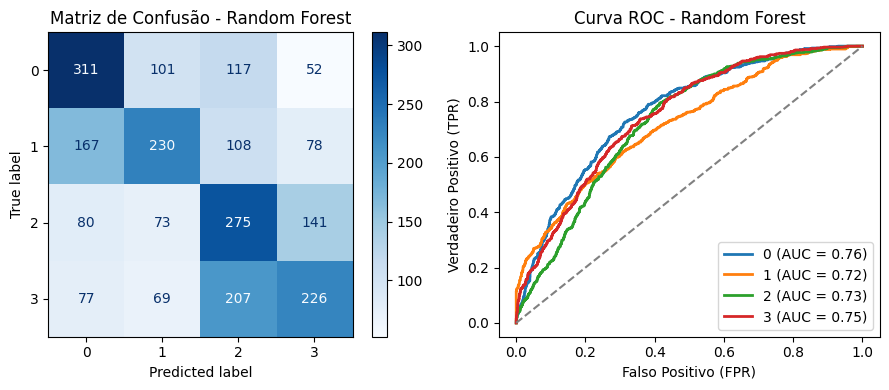


Avaliando Modelo: XGBoost
  - Accuracy: 0.4472
  - Precision: 0.4499
  - Recall: 0.4472
  - F1 Score: 0.4467


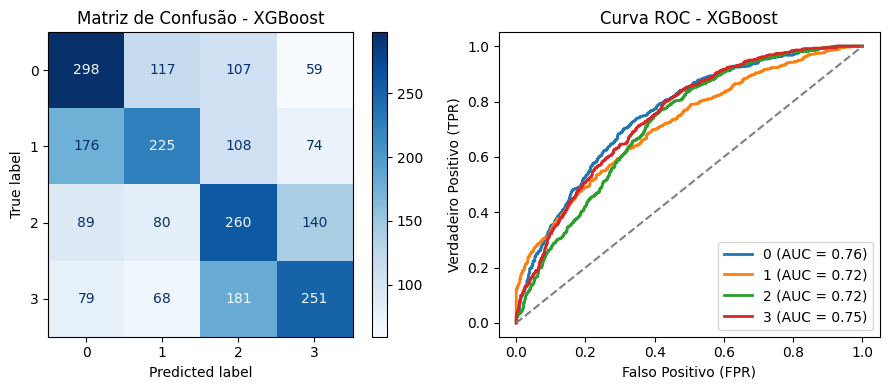


Avaliando Modelo: lighttgbm


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


  - Accuracy: 0.4386
  - Precision: 0.4418
  - Recall: 0.4386
  - F1 Score: 0.4380


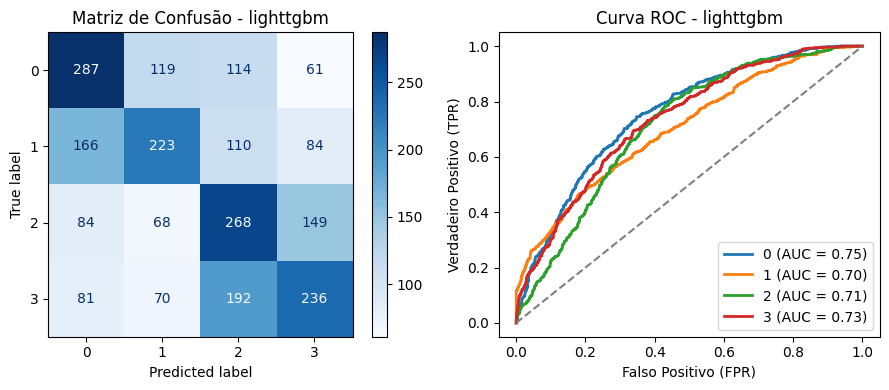


Avaliando Modelo: CATBoost
  - Accuracy: 0.4680
  - Precision: 0.4761
  - Recall: 0.4680
  - F1 Score: 0.4659


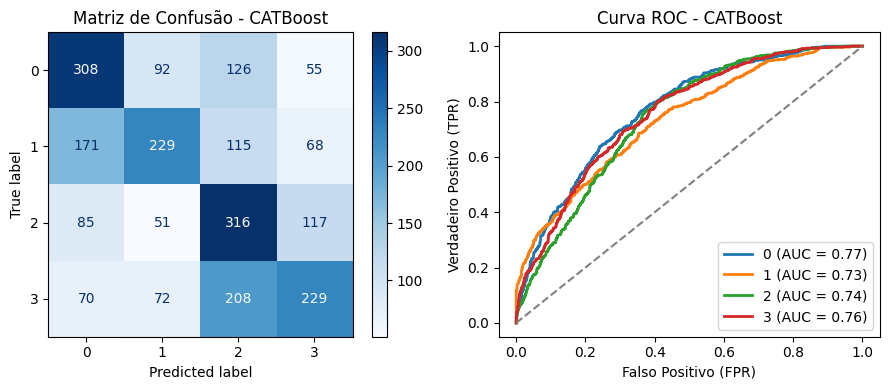

In [40]:
# Treinar e avaliar os modelos
for name, model in models.items():
    print(f"\nAvaliando Modelo: {name}")

    # Criar pipeline
    pipeline = create_pipeline(model)

    # Treinar o modelo
    pipeline.fit(X_train, y_train)

    # Fazer previsões no conjunto de teste
    y_pred = pipeline.predict(X_test)

    # Métricas de avaliação
    acc = accuracy_score(y_test, y_pred)
    # Changed to 'weighted' to handle multiclass classification
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"  - Accuracy: {acc:.4f}")
    print(f"  - Precision: {prec:.4f}")
    print(f"  - Recall: {rec:.4f}")
    print(f"  - F1 Score: {f1:.4f}")

    # Criar figura com 2 subplots lado a lado
    fig, axs = plt.subplots(1, 2, figsize=(9, 4))

    # Plotar Matriz de Confusão no primeiro subplot
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=axs[0], cmap='Blues', values_format='d')
    axs[0].set_title(f"Matriz de Confusão - {name}")

    # Assuming y_prob is the probability predictions (needs to be defined)
    y_prob = pipeline.predict_proba(X_test)

    # Iterate over each class to plot ROC curve for multi-class
    for i, class_name in enumerate(pipeline.classes_):
        fpr, tpr, _ = roc_curve(y_test, y_prob[:, i], pos_label=class_name)
        roc_auc = auc(fpr, tpr)
        axs[1].plot(fpr, tpr, lw=2, label=f'{class_name} (AUC = {roc_auc:.2f})')

    axs[1].plot([0, 1], [0, 1], color='gray', linestyle='--')
    axs[1].set_xlabel("Falso Positivo (FPR)")
    axs[1].set_ylabel("Verdadeiro Positivo (TPR)")
    axs[1].set_title(f"Curva ROC - {name}")
    axs[1].legend(loc="lower right")

    plt.tight_layout()
    plt.show()

Os modelos tiveram um desempenho bem baixo, observando o dataset acredito que essa fato se da a falta de dados, então vou focar ainda mais na Engenharia de Features para buscar melhorar as metricas. Ja utilizei do REN, agora vou utilizar do TF-IDF e da tecnica POS.

## TF-IDF (Term Frequency - Inverse Document Frequency)

Mede a frequência de uma palavra no texto e ajusta com base em quantos documentos essa palavra aparece.

Vamos limitar essa tecnicas novas ao corpo das postagens que seria onde temos textos mais longos.

In [45]:
stop_words_pt = stopwords.words('portuguese')

amostra_final['corpo'] = amostra_final['corpo'].fillna('')

tfidf = TfidfVectorizer(max_features=500, stop_words=stop_words_pt)
tfidf_matrix = tfidf.fit_transform(amostra_final['corpo'])


In [47]:
tfidf_matrix

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 88879 stored elements and shape (7706, 500)>